# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

In [2]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-09-13 13:41:43,942 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [3]:
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.6
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [4]:
from pathlib import Path
_work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

analyser.hyperparams.work_dir = work_dir
 

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/work


### Imports...

In [5]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


### Query DB for contact IDs

#### Load meta data CSV

In [6]:
export_fn = str(Path(work_dir) / 'contract_trainset_meta.temp.csv')
# stats = pd.read_csv(export_fn, index_col=0)

try:
    stats = pd.read_csv(export_fn, index_col=0)
    if not 'analyze_date' in stats:
        stats['analyze_date'] = None
    stats['analyze_date'] = pd.to_datetime(stats['analyze_date'])
    stats['user_correction_date'] = pd.to_datetime(stats['user_correction_date'])

    lastdate = stats[["user_correction_date", 'analyze_date']].max().max()
    
except Exception as ex:
    logger.exception(ex)
    logger.error(f'cannot load {export_fn}')

    lastdate = datetime(1900, 1, 1)
    stats = DataFrame()
    
if not IMPORT_FRESH_ONLY:
    lastdate = datetime(1900, 1, 1)
    
print(lastdate, export_fn)
stats

2021-08-02 13:33:06.624000 /Users/artem/work/nemo/work/contract_trainset_meta.temp.csv


,url,version,org-1-name,org-2-name,org-1-alias,org-2-alias,subject,value,user_correction_date,analyze_date,checksum,export_date,subject confidence,value_log1p,value_span,valid,currency,len
60b7a55b061c76d77545505a,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,7.000000e+08,2021-07-29 08:56:09.177,2021-06-04 21:39:30.461,51064791f578e6b4ba62f717a09832db,2021-07-29 14:20:27.093368,NaN,20.366591,1218.0,False,RUB,4088.0
60b7a4cc061c76d7754546b0,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Deal,4.285374e+08,2021-07-29 09:05:58.705,2021-06-03 06:10:15.320,1775ac8122d39314d9d8c7e8c0c03437,2021-07-29 14:20:25.189336,NaN,19.875888,563.0,NaN,RUB,774.0
60b7a5b1061c76d775455517,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,1.846700e+08,NaT,2021-06-05 16:36:09.054,50f010a37f21887b6d0242450c310cdb,2021-07-29 14:40:00.388647,NaN,19.034081,75.0,NaN,RUB,1062.0
60b7a5b1061c76d77545551e,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,2.969460e+07,NaT,2021-06-05 16:41:37.040,b14d88a9f8c9c698e7119e3c722267e2,2021-07-29 14:40:00.415121,NaN,17.206476,108.0,NaN,RUB,311.0
60b7a59a061c76d775455383,http://gpn-audit.nemosoft.ru/#/audit/edit/60b7...,2.3.14,NaN,NaN,NaN,NaN,Service,5.000000e+05,NaT,2021-06-05 10:03:03.705,2d78ec018ce5f8e710f0399e15a0f25f,2021-07-29 14:39:13.808920,NaN,13.122365,345.0,NaN,RUB,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60b7a595061c76d775455308,NaN,2.3.14,Газпромнефть-Каталитические системы,Измерительная техника,Заказчик,Исполнитель,Service,2.540000e+05,NaT,2021-06-05 08:14:43.166,21b3cefccb16f68f46eab84875555ad9,2021-07-29 14:38:53.843724,NaN,12.445093,277.0,NaN,RUB,4970.0
60b7a599061c76d775455369,NaN,2.3.14,Бизнес для бизнеса,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,1.200000e+05,NaT,2021-06-05 09:41:59.288,e91883d22724485a0f74c9961350acfa,2021-07-29 14:39:09.497453,NaN,11.695255,577.0,NaN,RUB,1370.0
60b7a5b5061c76d77545557a,NaN,2.3.14,Центр предпринимательских рисков,Газпромнефть-Каталитические системы,Исполнитель,Заказчик,Service,4.100000e+04,NaT,2021-06-05 18:15:41.276,d10b504216611046cb75a7b314568fcb,2021-07-29 14:40:16.223362,NaN,10.621352,1319.0,NaN,RUB,3527.0
60ebe82ecddbb3c487368c25,NaN,2.4.4,БДО Юникон,Газпром-нефть,Исполнитель,NaN,Service,NaN,NaT,2021-07-12 09:59:02.421,9afd3f4c0c6385de2e8fcc34cae08127,2021-07-29 14:40:18.736357,NaN,NaN,NaN,NaN,NaN,6045.0


## Fetch fresh docs from Mongo DB

In [7]:
from pymongo import ASCENDING

query = {
  '$and': [
    {"parse.documentType": "CONTRACT"},
      
    {"state": 15},
    {'$or': [
          {"analysis.attributes_tree": {"$ne": None}},
          {"user.attributes_tree": {"$ne": None}}
        ]},
#       {'$and': [
#           {"user.updateDate": {"$ne": None}},
#           {'user.updateDate': {'$gt': lastdate}}
#       ]}
#     {"user.attributes_tree.contract.people": {"$ne": None}}

    #     {'$or': [
    #         {"user.attributes_tree.contract.price.amount_netto": {"$ne": None}},
    #         {"user.attributes_tree.contract.price.amount_brutto": {"$ne": None}}
    #     ]}
    {'$or': [
      {'analysis.analyze_timestamp': {'$gt': lastdate}},
      {'user.updateDate': {'$gt': lastdate}}
    ]}
  ]
}

db = get_mongodb_connection()
documents_collection = db['documents']
sorting = [('analysis.analyze_timestamp', ASCENDING), ('user.updateDate', ASCENDING)]
res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}
#                                             'analysis.attributes_tree.version': True,
#                                             'analysis.attributes_tree.contract.subject': True}
                               ).limit(1000)

res = list([i for i in res])

_s = f"#### Всего новых документов после {lastdate} : {len(res)}"
display(Markdown(_s))

res[:4]

DB HOST IS: 192.168.10.36


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


#### Всего новых документов после 2021-08-02 13:33:06.624000 : 105

[{'_id': ObjectId('5fe34f64b770574a005553e2'),
  'user': {'updateDate': datetime.datetime(2021, 8, 25, 11, 0, 41, 377000)}},
 {'_id': ObjectId('60002adfb08473039387bcb0'),
  'user': {'updateDate': datetime.datetime(2021, 8, 25, 6, 47, 44, 147000)}},
 {'_id': ObjectId('60002adfb08473039387bcd3'),
  'user': {'updateDate': datetime.datetime(2021, 8, 25, 11, 4, 34, 203000)}},
 {'_id': ObjectId('60002adfb08473039387bcd6'),
  'user': {'updateDate': datetime.datetime(2021, 8, 26, 14, 28, 18, 504000)}}]

### docs having insideInformation

In [8]:
from pymongo import ASCENDING

query = {
  '$and': [
#     {"parse.documentType": "CONTRACT"},      
#     {"state": 15},
    {'$or': [
        {"user.attributes_tree.contract.subject.insideInformation": {"$ne": None}},
        {"user.attributes_tree.contract.insideInformation": {"$ne": None}}
    ]}
  ]
}

res = documents_collection.find(filter=query, 
                                sort=sorting,
                                projection={'_id': True, 'user.updateDate':True}

                               ).limit(1000)

res_inside = list([i for i in res])

_s = f"#### Всего документов с инсайдом {lastdate} : {len(res_inside)}"
display(Markdown(_s))

res_inside[:5]

#### Всего документов с инсайдом 2021-08-02 13:33:06.624000 : 81

[{'_id': ObjectId('60af4d8f0b62ae6e622cc161'),
  'user': {'updateDate': datetime.datetime(2021, 7, 30, 12, 14, 8, 564000)}},
 {'_id': ObjectId('60defc4e95588e4cfb432c28'),
  'user': {'updateDate': datetime.datetime(2021, 7, 23, 10, 22, 50, 433000)}},
 {'_id': ObjectId('60df005595588e4cfb432c2a'),
  'user': {'updateDate': datetime.datetime(2021, 7, 16, 10, 46, 21, 627000)}},
 {'_id': ObjectId('60ebf4a7cddbb3c487368c2d'),
  'user': {'updateDate': datetime.datetime(2021, 7, 15, 14, 37, 50, 295000)}},
 {'_id': ObjectId('60ec1da0cddbb3c487368c39'),
  'user': {'updateDate': datetime.datetime(2021, 7, 15, 14, 47, 33, 598000)}}]

In [9]:
lines=[]
for k, oid in enumerate([i["_id"] for i in res_inside]  ):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    tree=jd.user['attributes_tree']
    c = tree.get('contract', {})
    ins = c.get('insideInformation') or  c.get('subject', {}).get('insideInformation', {}) 
    print('-'*100)
    print(k, ins)
#     doc=jd.asLegalDoc()
#     quote = doc[ins['span']]
    doc = jd.asLegalDoc()
    s = ins['span']
    quote = doc[s[0]: s[1]].get_text()
    print(quote)
    lines.append( [oid, s[0], s[1], quote, ins['value']]  )
    
insides = DataFrame(lines, columns=['uid', 'from','to', 'text', 'value'])
insides

----------------------------------------------------------------------------------------------------
0 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [130, 199], 'span_map': 'words', 'value': 'Deals', 'changed': True, 'parent': 'subject'}
Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект
----------------------------------------------------------------------------------------------------
1 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [330, 529], 'span_map': 'words', 'value': 'Deals', 'changed': True, 'parent': ''}
3.1. Покупатель производит оплату общей стоим

----------------------------------------------------------------------------------------------------
14 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [1515, 1532], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
4.6. Представлять бухгалтерскую и прочую отчетность, подготовка которой осуществляется Заемщиком в соответствии с Законодательством,
----------------------------------------------------------------------------------------------------
15 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [112, 117], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
комплексное правовое сопровождение деятельности Заказчика


----------------------------------------------------------------------------------------------------
16 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [2894, 2912], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
Банк ВТБ открывает по просьбе Клиента Аккредитивы на основании Заявлений на Аккредитив при условии согласия с условиями Аккредитивов


----------------------------------------------------------------------------------------------------
17 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [398, 406], 'span_map': 'words', 'value': 'IssuedSecurities', 'changed': True, 'parent': 'subject'}
услуги, связанные с выпуском и обращением Облигаций
----------------------------------------------------------------------------------------------------
18 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [166, 173], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
аудита бухгалтерской (финансовой) отчетности Заказчика


----------------------------------------------------------------------------------------------------
19 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [94, 114], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
услуги по обзорной проверке (далее – «Услуги») следующей финансовой информации промежуточных сокращенных консолидированных финансовых отчетностей Клиента


----------------------------------------------------------------------------------------------------
20 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [514, 541], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
2.2.1. Предоставлять Банку всю необходимую, полную и достоверную информацию, которая может быть разумно потребована Банком для целей исполнения им своих обязательств по Соглашению.
----------------------------------------------------------------------------------------------------
21 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [2511, 2523], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Продавец передает Покупателю Долю, а Покупатель обязуется принять и оплатить Долю


----------------------------------------------------------------------------------------------------
22 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [426, 451], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывной оферты ("Оферта") предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи")
----------------------------------------------------------------------------------------------------
23 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [99, 168], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
Кредитор обязуется открыть Заемщику невозобновляемую кредитную линию для финансирования общекорпоративных целей Заемщика, в том числе финансирования текущих расходов Заемщика (включая, но не ограничиваясь: финансирование затрат на закупку 

----------------------------------------------------------------------------------------------------
25 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1481, 1541], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывных оферт предоставляет Акцептанту право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об уступке Акцептантом всех Прав Требования к Обществу (в том числе будущих Прав Требования, которые могут возникнуть после Даты Соглашения) ("Оферта 2", а совместно с Офертой 1 - "Оферты")


----------------------------------------------------------------------------------------------------
26 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1213, 1229], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи")


----------------------------------------------------------------------------------------------------
27 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [1454, 1508], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Клиент соглашается своевременно предоставлять или обеспечивать предоставление Консультанту такой финансовой и иной информации (включая все документы, договоры и учетную информацию), касающейся Сделки, которая имеет или может иметь отношение для понимания условий (финансовых или иных), бизнеса, результатов, операционных данных и перспектив Компании – Оператора Проекта


----------------------------------------------------------------------------------------------------
28 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [455, 457], 'span_map': 'words', 'value': 'IssuedSecurities', 'changed': True, 'parent': 'subject'}
размещения Облигаций
----------------------------------------------------------------------------------------------------
29 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [2650, 2683], 'span_map': 'words', 'value': 'SD', 'changed': True, 'parent': ''}
3.2.3. Предоставлять Регистратору информацию о решениях органов управления Эмитента, касающихся условий и порядка деятельности Эмитента и затрагивающих вопросы, носящие существенный характер для осуществления Регистратором своих обязанностей по настоящему Договору.


----------------------------------------------------------------------------------------------------
30 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [3021, 3042], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
копии годового бухгалтерского баланса и отчета о финансовых результатах Заемщика, включая копии приложений к указанным документам с отметкой налоговой инспекции
----------------------------------------------------------------------------------------------------
31 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [109, 115], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
комплекс услуг по ведению бухгалтерского учета
----------------------------------------------------------------------------------------------------
32 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [203, 211], 'span_map': 'words',

----------------------------------------------------------------------------------------------------
37 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [871, 880], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
разработку и реализацию стратегии продажи Обществ совместно с Клиентом
----------------------------------------------------------------------------------------------------
38 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [145, 173], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
услуги («Услуги») по сложным методологическим вопросам учета и представления информации в отчетности в соответствии с Международными стандартами финансовой отчетности («МСФО»)
----------------------------------------------------------------------------------------------------
39 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'sp

----------------------------------------------------------------------------------------------------
42 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [500, 523], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
защиты Конфиденциальной информации, предоставленной Раскрывающей стороной Принимающей стороне с целью получения информации об оборудовании планируемому к ОПИ/ПЭ (Опытно-промышленные испытания/подконтрольная эксплуатация)
----------------------------------------------------------------------------------------------------
43 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [6557, 6625], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Предоставлять Кредитору ежеквартально не позднее 10 (Десяти) рабочих дней с даты окончания календарного месяца, следующего за отчетным периодом (кварталом, полугодием, 9 (Девятью) месяцами), а по окончании отчетного год

----------------------------------------------------------------------------------------------------
44 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1688, 1753], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об уступке Акцептантом всех Прав Требования к Обществу (в том числе будущих Прав Требования, которые могут возникнуть после Даты Соглашения) ("Оферта 2", а совместно с Офертой 1 - "Оферты"), на условиях, предусмотренных Соглашением ("Опцион")
----------------------------------------------------------------------------------------------------
45 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [108, 114], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
услуги по определению стоимости объекта оценки
--------------------------------

----------------------------------------------------------------------------------------------------
47 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [1204, 1241], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывной оферты ("Оферта") предоставляет Акцептанту право заключить договор купли-продажи принадлежащей Оференту Выкупаемой доли ("Договор купли-продажи"), на условиях, предусмотренных настоящим Соглашением ("Опцион")


----------------------------------------------------------------------------------------------------
48 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [163, 234], 'span_map': 'words', 'value': 'SharesOfParticipation', 'changed': True, 'parent': 'subject'}
Оферент посредством безотзывных оферт предоставляет Акцептанту право заключить договор купли-продажи Отчуждаемой Доли ("Оферта 1") совместно с соглашением об уступке Акцептантом всех Прав Требования к Обществу (в том числе будущих Прав Требования, которые могут возникнуть после Даты Соглашения) ("Оферта 2", а совместно с Офертой 1 - "Оферты"), на условиях, предусмотренных Соглашением ("Опцион")
----------------------------------------------------------------------------------------------------
49 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [140, 150], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
поставку Поку

----------------------------------------------------------------------------------------------------
50 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [2853, 2877], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
предоставляются копии платежных поручений о перечислении указанных сумм (с отметкой об исполнении) и (или) налоговых деклараций (бухгалтерской отчетности)
----------------------------------------------------------------------------------------------------
51 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [121, 128], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': 'subject'}
оказать Заказчику услуги по поддержке информационных систем
----------------------------------------------------------------------------------------------------
52 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [6343, 6406], 'span_map': 'words'

----------------------------------------------------------------------------------------------------
54 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [11720, 11762], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
11.2.8. Предоставлять в Банк ВТБ или обеспечить на ежеквартальной основе размещение на официальном сайте Клиента в сети «Интернет» (http://www. gazprom-neft. ru) копии актуальной бухгалтерской отчетности Клиента по РСБУ, заверенной уполномоченными лицами Клиента
----------------------------------------------------------------------------------------------------
55 {'confidence': 1, 'kind': 'insideInformation', 'key': 'subject/insideInformation', 'span': [268, 282], 'span_map': 'words', 'value': 'Plans', 'changed': True, 'parent': 'subject'}
Общество передает Интерфакс-ЦРКИ информацию, подлежащую раскрытию Обществом согласно требованиям действующего законодательства Российской Федерации
---------------------------

----------------------------------------------------------------------------------------------------
60 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [5133, 5138], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
на основании зарегистрированной отчетности компании
----------------------------------------------------------------------------------------------------
61 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [149, 169], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}
Анализ бухгалтерской (финансовой) отчетности обществ, входящих в Группу Газпром нефть, в рамках работы ревизионных комиссий.
----------------------------------------------------------------------------------------------------
62 {'confidence': 1, 'kind': 'insideInformation', 'key': 'insideInformation', 'span': [147, 174], 'span_map': 'words', 'value': 'Accounting', 'changed': True, 'parent': ''}

,uid,from,to,text,value
0,60af4d8f0b62ae6e622cc161,130,199,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
1,60defc4e95588e4cfb432c28,330,529,3.1. Покупатель производит оплату общей стоимо...,Deals
2,60df005595588e4cfb432c2a,142,171,"2.1. Заказчик поручает, а Исполнитель принимае...",Accounting
3,60ebf4a7cddbb3c487368c2d,129,201,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
4,60ec1da0cddbb3c487368c39,129,200,"Заказчик поручает и обязуется оплатить, а Испо...",Deals
...,...,...,...,...,...
76,612f5cb9ea1085618e03000f,152,190,Анализ бухгалтерской (финансовой) отчетности с...,Accounting
77,612f5cb9ea1085618e030011,147,192,Подготовка раскрытий для промежуточной сокраще...,Accounting
78,612f5cb9ea1085618e030013,144,253,• проверка отчетов об оценке рыночной стоимост...,Accounting
79,612f5cb9ea1085618e030017,143,167,Услуги по сопровождению и администрированию пр...,Accounting


In [10]:
insides = insides.drop_duplicates(subset=['text'], keep='last')
insides.sort_values(['value']).to_csv('insides.csv', index=True)

In [11]:
from tf_support.embedder_elmo import ElmoEmbedder

embedder = ElmoEmbedder.get_instance()


DEBUG:gpn:creating ElmoEmbedderImpl instance


In [12]:
strings = [ r.text for i,r in  insides.iterrows() ]
strings[2:8]

['Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект»)',
 'Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект',
 'Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический ко

In [13]:
#just test
t1 = insides.iloc[0].text
t2 = insides.iloc[1].text
print(t1, t1)
embeddings = embedder.embedd_strings([t1, t2])
print(embeddings)

INFO:gpn:< loading ELMO module https://storage.googleapis.com/az-nlp/elmo_ru-news_wmt11-16_1.5M_steps.tar.gz
INFO:gpn:TF hub cache dir is  /Users/artem/work/nemo/work/tf_cache


3.1. Покупатель производит оплату общей стоимости Объектов, указанной в пункт 2.1 Договора, денежными средствами на расчетный счет Продавца, указанный в настоящем Договоре;
3.2. Датой оплаты стоимости Объектов считается дата поступления денежных средств на расчетный счет Продавца.
3.3. Настоящим Договором устанавливается ипотека на объект - Нежилое двухэтажное здание, используемое под офис, общая площадь 1035 кв. м, кадастровый (или условный) номер: 72:11:0102003:141, в пользу Продавца до полного расчета по Договору.
3.3. В случае если платежи, предусмотренные абзацами 1 и 2 пункта 3.1 договора, не будут произведены в срок, установленный договором, действие настоящего Договора прекращается, а Объекты Продавцом Покупателю не передаются. 
3.4. Все расчеты, предусмотренные пунктом 3.1. настоящего Договора, Покупатель производит денежными средствами в рублях на расчетный счет Продавца в банке по реквизитам Продавца, указанным в разделе 14 настоящего договора.
3.5. Покупатель, по своему усм

INFO:gpn:ELMO module loaded >
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2021-09-13 13:42:45.360143: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:gpn:graph finalized >>


[[-0.04930597  0.13300575  0.02279849 ...  0.25764862  0.20679747
   0.6355051 ]
 [ 0.02963619  0.34205717  0.0704807  ...  0.0230176  -0.10573081
   0.1769688 ]]


In [14]:
embeddings = embedder.embedd_strings(strings)

(74, 1024)


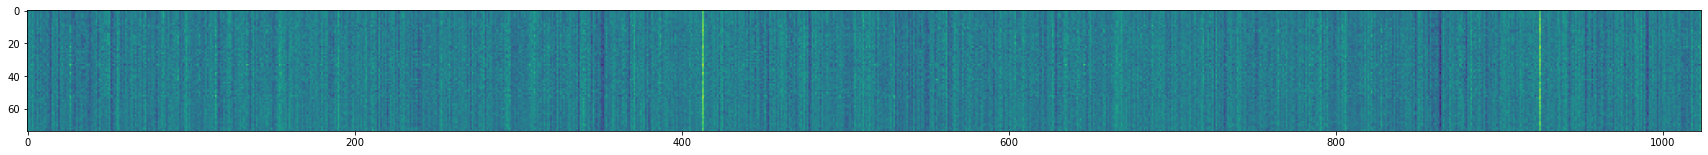

In [61]:
print(embeddings.shape)

plt.figure(figsize=(30,10))
plt.imshow(embeddings)


## pair-wise distances of Embeddings, removing duplicates

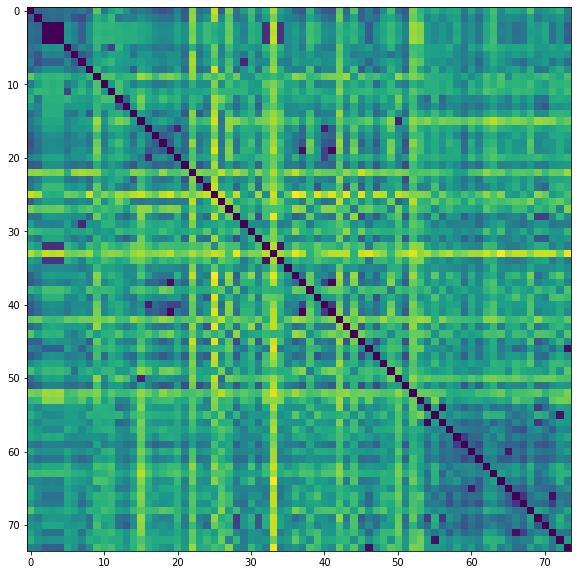

In [22]:
from sklearn.metrics import pairwise_distances
X = embeddings
distance_matrix = pairwise_distances(X, X, metric='cosine', n_jobs=1)
distance_matrix

plt.figure(figsize=(10,10))
plt.imshow(distance_matrix)

In [55]:
_excluded = set()
_kept = set()

display(Markdown('### Одинаковые:'))
for i in range(distance_matrix.shape[0]):
    for j in range(i+1, distance_matrix.shape[0]):
        d = distance_matrix[i,j]
        if d < 0.1:
            print(i,'vs', j, ', cosine distance =',d)
            _kept.add(i)
            _excluded.add(j)
            print(i, strings[i])
            print('==')
            print(j, strings[j])
            print('-'*100)
# _excluded

print(_kept-_excluded)
print(_excluded)

### Одинаковые:

2 vs 3 , cosine distance = 0.0077768564
2 Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект»)
==
3 Заказчик поручает и обязуется оплатить, а Исполнитель обязуется: осуществить Авторский надзор за строительством объектов Заказчика (далее - «Услуги»): «Лабораторно-аналитический комплекс. Строительство производства катализаторов 1 этап» и «Объекты основного производства и ОЗХ. Строительство производства катализаторов 2 этап», находящихся по адресу: 644040, г. Омск, пр. Губкина, дом 1 (далее - «Объект
----------------------------------------------------------------------------------------------------
2 vs 4 , cosine distance = 0.00085633993
2

In [60]:
import numpy as np
embeddings_filtered = np.delete(embeddings, list(_excluded), axis=0)
embeddings_filtered.shape

(60, 1024)

## Clustering, t-SNE try

In [150]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1300)
tsne_results = tsne.fit_transform(embeddings)

[t-SNE] Computing 73 nearest neighbors...
[t-SNE] Indexed 74 samples in 0.000s...
[t-SNE] Computed neighbors for 74 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 74 / 74
[t-SNE] Mean sigma: 4.080719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.533478
[t-SNE] KL divergence after 1000 iterations: 0.155629


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

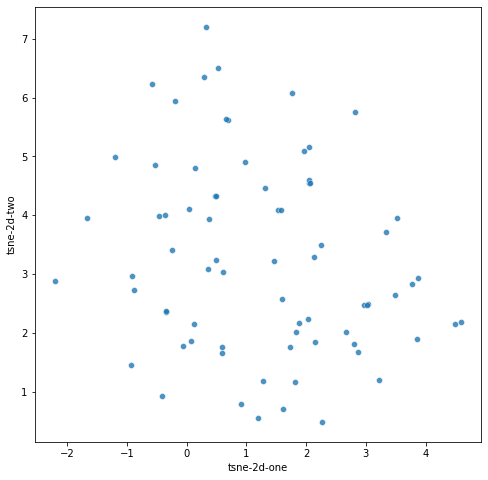

In [151]:
df_subset={}
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    data=df_subset,
    alpha=0.8
)

## Clustering, PCA try

74 [[-2.4846377   2.1767952 ]
 [ 3.1886566   1.39817   ]
 [-0.01804813 -2.860679  ]
 [-2.9533312  -1.4030621 ]
 [ 2.4523497  -0.85173744]
 [ 0.16636954  0.8939569 ]]


<AxesSubplot:xlabel='pca2d-one', ylabel='pca2d-two'>

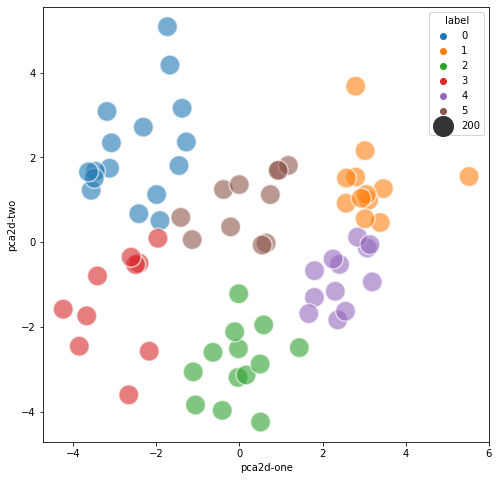

In [140]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

df_subset={}
df_subset['pca2d-one'] = pca_result[:,0]
df_subset['pca2d-two'] = pca_result[:,1]


from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=6, random_state=0).fit(np.array(pca_result))
print(len(kmeans.labels_), kmeans.cluster_centers_)
# print(len(kmeans.labels_), kmeans.labels_)

df_subset['label'] = kmeans.labels_

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="pca2d-one", y="pca2d-two",
    data=df_subset,
    hue="label", palette="tab10",
    alpha=0.6, size=[200]*len(kmeans.labels_), sizes=(400, 500)
)
# print(pca_result[:3])

In [135]:
# kmeans.labels_

insides['auto_labels'] = -1
# kmeans.labels_
insides['auto_labels']=kmeans.labels_


In [142]:
insides=insides.sort_values(['auto_labels']).to_csv('insides.csv', index=True)


# Prepare training set

In [ ]:
from datetime import datetime
from math import log1p

from pandas import DataFrame

from analyser.persistence import DbJsonDoc
from trainsets.retrain_contract_uber_model import flatten_attributes_tree


def add_stats_record(d: DbJsonDoc, stats: DataFrame):
  _id = str(d.get_id())

  attr_map = flatten_attributes_tree(d.get_attributes_tree())

  # stats.at[_id, 'valid'] = True

  stats.at[_id, 'checksum'] = d.get_tokens_for_embedding().get_checksum()
  if 'version' in d.analysis['attributes_tree']:
    stats.at[_id, 'version'] = '.'.join([str(x) for x in d.analysis['attributes_tree']['version']])
  else:
    stats.at[_id, 'version'] = d.analysis['version']

  stats.at[_id, 'export_date'] = datetime.now()
  stats.at[_id, 'len'] = len(d)
  stats.at[_id, 'analyze_date'] = d.analysis['analyze_timestamp']


  _value_tag = attr_map['sign_value_currency/value']
  if _value_tag:
    stats.at[_id, 'value'] = _value_tag['value']
    stats.at[_id, 'value_log1p'] = log1p(_value_tag['value'])
    stats.at[_id, 'value_span'] = _value_tag['span'][0]
    # find_in_dict('price.amount.span.0', d.get_attributes_tree())
    
  def _map_val(src, dest):
    if attr_map[src]:
        stats.at[_id, dest] = attr_map[src]['value']
        
  _map_val('sign_value_currency/currency', 'currency')
  _map_val('org-1-alias', 'org-1-alias')
  _map_val('org-2-alias', 'org-2-alias')
  _map_val('org-1-name', 'org-1-name')
  _map_val('org-2-name', 'org-2-name')
  _map_val('subject', 'subject')
 


  if d.user is not None:
    # if 'attributes_tree' in d.user and 'creation_date' in d.user['attributes_tree']:
    # stats.at[_id, 'user_correction_date'] = d.user['attributes_tree']['creation_date']
    stats.at[_id, 'user_correction_date'] = d.user[
      'updateDate']  # find_in_dict('attributes_tree.creation_date', d.user)


In [ ]:
# res[:4]
# from tqdm import tqdm

docs_ids = [i["_id"] for i in res]   
# stats = DataFrame()
    

for k, oid in enumerate(docs_ids):
    d = get_doc_by_id(oid)
    jd = DbJsonDoc(d)
    
    add_stats_record(jd, stats)
    
    if k % 20 == 0:
        print(k)
        stats.to_csv(export_fn, index=True)
    
stats.to_csv(export_fn, index=True)
stats

In [ ]:
stats2 = stats.copy()
stats2['org-2-alias'] = stats2['org-2-alias'].str.lower()
stats2['org-1-alias'] = stats2['org-1-alias'].str.lower()
stats2['org-1-name'] = stats2['org-1-name'].str.lower()
stats2['org-2-name'] = stats2['org-2-name'].str.lower()
stats2

In [ ]:
stats2['subject'].value_counts()

In [ ]:
stats2['org-1-alias'].value_counts()

In [ ]:
stats2['org-2-alias'].value_counts()

In [ ]:
score_column_name = "score"

def calc_no_value_importance(stats2, column_name, score_k=2.):
        
    for i, row in stats2.iterrows():
        if pd.isna(row[column_name]):
            stats2.at[i, score_column_name] *= score_k
                
def calc_user_importance(stats2):
        
    for i, row in stats2.iterrows():
        if not pd.isna(row['unseen']):

            if row['unseen'] == True:
                stats2.at[i, score_column_name] *= 2
                
def calc_val_importance(stats2):
 
    for i, row in stats2.iterrows():
        if not pd.isna(row['value']):
            val = row['value']
            if val >= 2000:
                stats2.at[i, score_column_name] *= 1./log1p(val)
            if val < 2000:
                stats2.at[i, score_column_name] *= 4.
        else:
            stats2.at[i, score_column_name] *= 10.0 #error
            
def calc_column_val_importance(stats2, column_name, k=1):
    counts = stats2[column_name].value_counts()
 
        
    for i, row in stats2.iterrows():
        val = row[column_name]
        if val in counts:
            count = counts[val]
            stats2.at[i, score_column_name] *= k * log1p(count)
#             print(count, log1p(count),  1./log1p(count))
        else:
            stats2.at[i, score_column_name] *= 10.0 #error

            
for i, row in stats2.iterrows():        
  stats2.at[i, 'url'] = f'http://gpn-audit.nemosoft.ru/#/audit/edit/{i}'

    
stats2 ['unseen'] = pd.isna( stats2['user_correction_date'])

stats2[score_column_name] = 1.
 

calc_no_value_importance(stats2, 'org-1-alias', 2.)
calc_no_value_importance(stats2, 'org-2-alias', 2.)
calc_no_value_importance(stats2, 'org-1-name', 3.)
calc_no_value_importance(stats2, 'org-2-name', 3.)
calc_no_value_importance(stats2, 'user_correction_date', 10.)
calc_no_value_importance(stats2, 'subject', 4.)
calc_no_value_importance(stats2, 'value', 5.)

## calc_column_val_importance(stats2, 'org-1-name')
## calc_column_val_importance(stats2, 'org-2-name')

calc_column_val_importance(stats2, 'org-1-alias')
calc_column_val_importance(stats2, 'org-2-alias')
calc_column_val_importance(stats2, 'subject', k = 3.)

calc_user_importance(stats2)
calc_val_importance(stats2)

# drop_duplicates(subset=['checksum']).
stats2 = stats2.sort_values([score_column_name], ascending=True)
stats2.head(40)

In [ ]:
# sub = stats2.sort_values(['score'], ascending=True).copy()
# sub

## Find and remove duplicates

In [ ]:
stats2['len'] //= 5 #similar lens
stats2['len'] *= 5 #similar lens
stats2.sort_values(['len', 'org-1-name', 'org-2-name', 'org-1-alias','org-2-alias', 'value', 'subject'], ascending=False)

In [ ]:
for i, row in stats2.iterrows():
  _str = ':'.join(sorted([str(x) for x in
                          [row['len'], row['org-1-alias'], row['org-2-alias'], row['org-1-name'], row['org-2-name'],
                           row['value'], row['subject']]]))
  stats2.at[i, 'hash'] = hash(_str)

stats2 = stats2.sort_values(['hash'])


In [ ]:
unks = stats2['hash'].value_counts()

for i, row in stats2.iterrows():   
    stats2.at[i, 'dups'] = unks[row['hash']]
    
dups = stats2.sort_values(['dups', 'hash'], ascending=False)
# dups.to_csv(Path(work_dir) / 'contract_trainset_meta.duplicates.csv', index=True)

# dups[40:].head(40)
len(dups)

In [ ]:
unks

### Drop duplicates

In [ ]:
dups_s = dups.sort_values([score_column_name], ascending=True).copy()

dups_s = dups_s.drop_duplicates(subset=['hash'])
dups_s = dups_s.sort_values([score_column_name], ascending=True)


dups_s = dups_s.sort_values([score_column_name], ascending=True)
dups_s = dups_s[dups_s[score_column_name] < 5000]

# dups_s [dups_s['len'] > 30000].head(40)

## Remove rare subjects and very long docs

In [ ]:
plt.figure(figsize=(12, 8))
ax = dups_s[dups_s['len'] < 30000] ['len'].plot.hist(bins=40, alpha=0.8)

In [ ]:
plt.figure(figsize=(12, 8))
ax = dups_s[score_column_name].plot.hist(bins=5, alpha=0.8)

In [ ]:

dups_s['valid'] = True

print("excluding too long docs")
for i, row in dups_s.iterrows():   
    if row['len']>30000:
        print ('excluding', row[0], row['subject'], row['len'])
        dups_s.at[i, 'valid'] = False  
        
dups_s = dups_s[dups_s['valid'] == True]

print("excluding docs with rare subj")
cnts = dups_s ['subject'].value_counts()
for i, row in dups_s.iterrows():   
    if not pd.isna(row['subject']):
        if cnts[row['subject']] < 8:
            print ('excluding', row[0], row['subject'])
            dups_s.at[i, 'valid'] = False

dups_s = dups_s[dups_s['valid'] == True]  

In [ ]:
%matplotlib inline

cnt = dups_s['subject'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=cnt.values, y=cnt.index)

plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()
print(cnt)

In [ ]:
dups_s.to_csv(Path(work_dir) / 'contract_trainset_meta.good.csv', index=True)


_s = f"### {len(dups_s)} - Всего новых документов в обучающем наборе на {lastdate}"
display(Markdown(_s))


dups_s

In [ ]:
dups_s[dups_s['unseen']].to_csv(Path(work_dir) / 'contract_trainset_meta.to_markup.csv', index=True)

In [ ]:
dups_s[dups_s['unseen']]